### Import
For Load Data Section

In [1]:
import os
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import module_plot as m_plot # local module
import importlib

# Load Data

To develop a generalizable architecture for fault diagnosis, we utilize two benchmark datasets: **KAIST** and **CWRU**.

- **KAIST Dataset:** The Korea Advanced Institute of Science & Technology (KAIST) dataset contains vibration signals from rotating machinery under various fault types, motor loads, and fault severities. It provides a diverse set of conditions, making it suitable for robust model training and evaluation.

- **CWRU Dataset:** The Case Western Reserve University (CWRU) bearing dataset is widely used for bearing fault diagnosis research. It includes vibration data collected under different fault types, locations, and loads.

By training the ML model on both KAIST and CWRU datasets, we aim to demonstrate its ability to generalize across different machines, fault types, and operating conditions.

## KAIST Dataset

The KAIST Dataset (Jung2022) has 4 sensed variables: acoustic, current, temperature, and vibration. In this case, only vibration will be used.
- **Machine Conditions (Normal, BPFI, BPFO, Misalign, and Unbalance):** Fault types and normal operating condition
- **Motor load (0Nm, 2Nm, 4Nm):** Torque applied to the motor simulating load
- **Fault Severity:** Depending on the type of fault there are at least 3 severities. For example BPFI has a fault severity represented in the crack width (0.3mm, 1mm, 3mm)

In [2]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio

# ------------------------------ KAIST Dataset ------------------------------
vibration_mat_folder_kaist = '../../data/raw_kaist/vibration_mat_25.6kHz'
sampling_rate_kaist = 25600  # fixed at 25.6 kHz

# Mapping original → unified
kaist_map = {
    '0Nm_Normal': 'Normal',
    '0Nm_BPFI_03': 'BPFI',
    '0Nm_BPFO_03': 'BPFO',
    '0Nm_Misalign_01': 'Misalign',
    '0Nm_Unbalance_0583mg': 'Unbalance'
}

def load_domain_data_kaist(class_labels, domain_name, label_map=None):
    """Load vibration data for a KAIST domain with emoji-style verbose logging."""
    vibration_data = {}
    folder_path = f'../../data/flex-data/kaist_csv/vibration{sampling_rate_kaist/1000}kHz_domain{domain_name}'
    os.makedirs(folder_path, exist_ok=True)

    print(f"🚀 Loading KAIST domain {domain_name}...")
    for label in class_labels:
        unified_label = label_map[label] if label_map else label
        csv_path = f'{folder_path}/{label}.csv'
        mat_path = os.path.join(vibration_mat_folder_kaist, f"{label}.mat")

        if os.path.exists(csv_path):
            print(f"📂 Loading cached CSV for {label} → {unified_label}")
            data = pd.read_csv(csv_path).values.astype('float32')
        elif os.path.exists(mat_path):
            print(f"📥 Loading {label} from .mat as {unified_label}")
            m = sio.loadmat(mat_path)
            data = m['Signal']['y_values'][0][0][0][0][0].astype('float32')
            pd.DataFrame(data).to_csv(csv_path, index=False)
            print(f"💾 Saved CSV {csv_path}")
        else:
            print(f"❌ {label} not found")
            continue

        if unified_label not in vibration_data:
            vibration_data[unified_label] = []
        vibration_data[unified_label].append(data)

    for k in vibration_data:
        print(f"🔗 Concatenating {len(vibration_data[k])} segments for class {k}")
        vibration_data[k] = np.concatenate(vibration_data[k], axis=0)

    print(f"✅ Finished loading KAIST: {list(vibration_data.keys())}")
    return vibration_data

# Example usage
vibration_data_kaist_unified = load_domain_data_kaist(list(kaist_map.keys()), '0Nm', label_map=kaist_map)
class_labels_kaist_unified = list(vibration_data_kaist_unified.keys())


🚀 Loading KAIST domain 0Nm...
📂 Loading cached CSV for 0Nm_Normal → Normal
📂 Loading cached CSV for 0Nm_BPFI_03 → BPFI
📂 Loading cached CSV for 0Nm_BPFO_03 → BPFO
📂 Loading cached CSV for 0Nm_Misalign_01 → Misalign
📂 Loading cached CSV for 0Nm_Unbalance_0583mg → Unbalance
🔗 Concatenating 1 segments for class Normal
🔗 Concatenating 1 segments for class BPFI
🔗 Concatenating 1 segments for class BPFO
🔗 Concatenating 1 segments for class Misalign
🔗 Concatenating 1 segments for class Unbalance
✅ Finished loading KAIST: ['Normal', 'BPFI', 'BPFO', 'Misalign', 'Unbalance']


### Plot Random KAIST signal

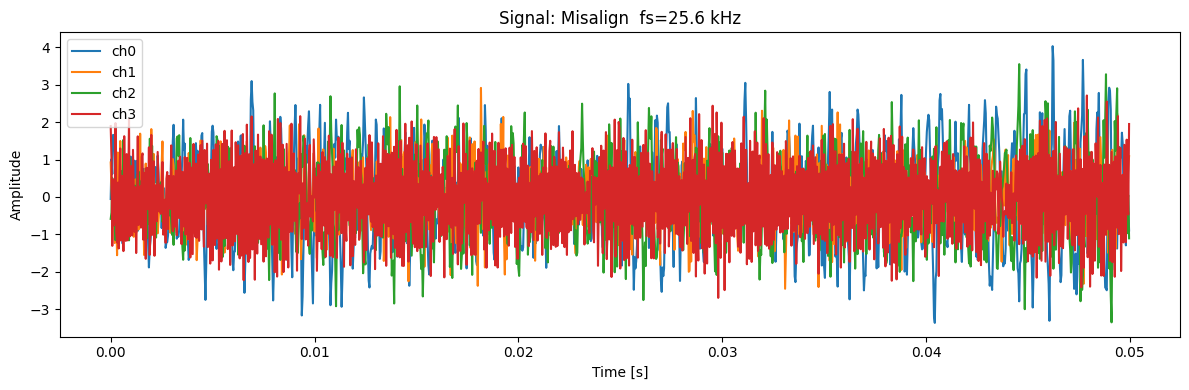

In [3]:
# Plot KAIST signals
m_plot.plot_signal(vibration_data_kaist_unified, fs=sampling_rate_kaist, seconds=0.05) # plots random examples from all classes
# m_plot.plot_signal(vibration_data_kaist, fs=sampling_rate_kaist, seconds=0.05, label='0Nm_Normal', channels=[0])

## CWRU Dataset

The Case Western Reserve University (CWRU) Bearing Dataset provides vibration measurements collected from a motor test rig with seeded bearing faults. Acceleration data was captured near the motor bearings under varying load and fault conditions.

- **Machine Conditions (Normal, Inner Race, Outer Race, and Ball Faults):** Single-point faults were introduced using electro-discharge machining (EDM) at the inner race, outer race, or rolling element. Normal operating condition data is also included.  
- **Motor Load (0–3 hp):** Torque loads applied to the 2 hp Reliance Electric motor, corresponding to operating speeds between 1720 and 1797 RPM.  
- **Fault Severity:** Fault diameters of 0.007, 0.014, 0.021, 0.028, and 0.040 inches were tested. SKF bearings were used for smaller faults (7–21 mils) and NTN bearings for larger faults (28–40 mils).  
- **Sensor Setup:** Vibration was recorded using accelerometers placed at the 12 o’clock position of the drive end and fan end bearings. Additional measurements were taken at the base plate in some experiments.  
- **Sampling Rate:** Signals were collected at 12 kHz for most cases, with 48 kHz recordings available for drive end bearing faults.  


In [3]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.signal import resample_poly

# ------------------------------ CWRU Dataset ------------------------------
vibration_mat_folder_cwru = '../../data/raw_cwru/vibration_mat_12kHz'
sampling_rate_cwru = 12000
target_sampling_rate_cwru = 25600

# Exact 12 kHz to 25.6 kHz ratio
UPSAMPLE, DOWNSAMPLE = 32, 15
assert target_sampling_rate_cwru * DOWNSAMPLE == sampling_rate_cwru * UPSAMPLE

def load_domain_data_cwru(class_labels, domain_name, label_map=None, max_src_len=260868):
    """Load CWRU domain with emoji style verbose logging. Resamples to target rate and remaps labels if label_map is given."""
    vibration_data = {}
    folder_path = f'../../data/flex-data/cwru_csv/vibration{target_sampling_rate_cwru/1000}kHz_domain{domain_name}'
    os.makedirs(folder_path, exist_ok=True)

    print(f"🚀 Loading CWRU domain {domain_name} at {target_sampling_rate_cwru} Hz...")
    for label in class_labels:
        unified_label = label_map[label] if label_map else label
        csv_path = f'{folder_path}/{label}.csv'
        mat_path = os.path.join(vibration_mat_folder_cwru, f"{label}.mat")

        if os.path.exists(csv_path):
            print(f"📂 Loading cached CSV for {label} → {unified_label}")
            data_resampled = pd.read_csv(csv_path).values.astype(np.float32)

        elif os.path.exists(mat_path):
            print(f"📥 Loading {label} from .mat as {unified_label}")
            m = sio.loadmat(mat_path)

            # Extract DE FE BA if present
            series, lengths = [], []
            for ch in ('DE', 'FE', 'BA'):
                key = next((k for k in m.keys() if not k.startswith('__') and k.endswith(f'_{ch}_time')), None)
                if key:
                    a = np.asarray(m[key]).squeeze().astype(np.float32)
                    if a.ndim != 1:
                        a = a.reshape(-1)
                    series.append(a)
                    lengths.append(a.shape[0])

            if not series:
                print(f"❌ No DE FE BA channels in {label}. Skipping")
                continue

            n = min(min(lengths), int(max_src_len))
            x = np.stack([s[:n] for s in series], axis=1)  # [T, C]

            print(f"🔄 Resampling {label} from {sampling_rate_cwru} Hz → {target_sampling_rate_cwru} Hz")
            data_resampled = resample_poly(x, UPSAMPLE, DOWNSAMPLE, axis=0).astype(np.float32)

            pd.DataFrame(data_resampled).to_csv(csv_path, index=False)
            print(f"💾 Saved CSV {csv_path}")

        else:
            print(f"⚠️ {label} not found in cache or mats")
            continue

        if unified_label not in vibration_data:
            vibration_data[unified_label] = []
        vibration_data[unified_label].append(data_resampled)

    # Concatenate per class using common channel count
    for k in list(vibration_data.keys()):
        print(f"🔗 Concatenating {len(vibration_data[k])} segments for class {k}")
        cmin = min(arr.shape[1] for arr in vibration_data[k])
        vibration_data[k] = np.concatenate([arr[:, :cmin] for arr in vibration_data[k]], axis=0).astype(np.float32)

    print(f"✅ Finished loading CWRU: {list(vibration_data.keys())}")
    return vibration_data

# Mapping CWRU with KAIST call style
cwru_map = {
    'Normal_0': 'Normal',
    'IR007_0':  'BPFI',
    'OR007@3_0': 'BPFO',
    'OR007@6_0': 'BPFO',
    'OR007@12_0': 'BPFO',
    'B007_0':   'Ball',   # change to 'BPFI' if you prefer the intersection scheme
}

vibration_data_cwru_unified = load_domain_data_cwru(list(cwru_map.keys()), '0HP', label_map=cwru_map)
class_labels_cwru_unified = list(vibration_data_cwru_unified.keys())


🚀 Loading CWRU domain 0HP at 25600 Hz...
📂 Loading cached CSV for Normal_0 → Normal
📂 Loading cached CSV for IR007_0 → BPFI
📂 Loading cached CSV for OR007@3_0 → BPFO
📂 Loading cached CSV for OR007@6_0 → BPFO
📂 Loading cached CSV for OR007@12_0 → BPFO
📂 Loading cached CSV for B007_0 → Ball
🔗 Concatenating 1 segments for class Normal
🔗 Concatenating 1 segments for class BPFI
🔗 Concatenating 3 segments for class BPFO
🔗 Concatenating 1 segments for class Ball
✅ Finished loading CWRU: ['Normal', 'BPFI', 'BPFO', 'Ball']


Plot Random signal CWRU

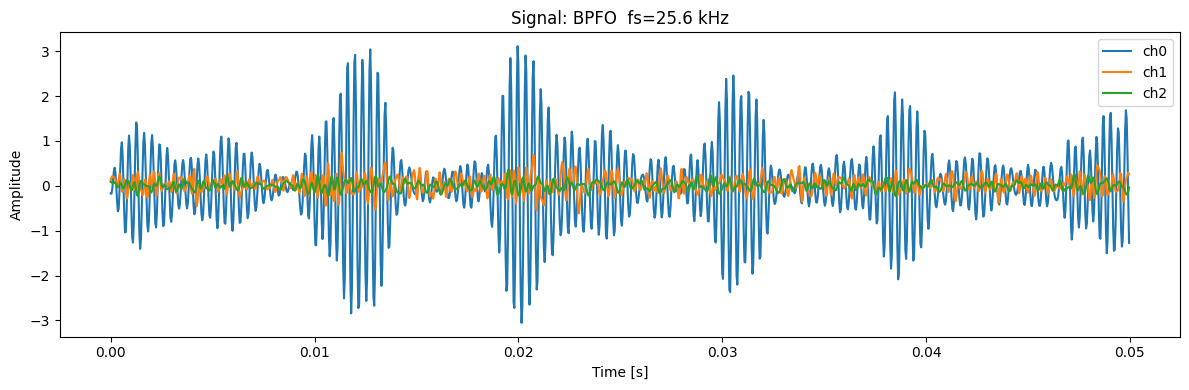

In [5]:
# CWRU after your resampling step at 25.6 kHz
m_plot.plot_signal(vibration_data_cwru_unified, fs=target_sampling_rate_cwru, seconds=0.05) # plots random examples from all classes
# m_plot.plot_signal(vibration_data_cwru, fs=sampling_rate_cwru, seconds=0.05, label='Normal_0')

### Resampling visualization CWRU Dataset

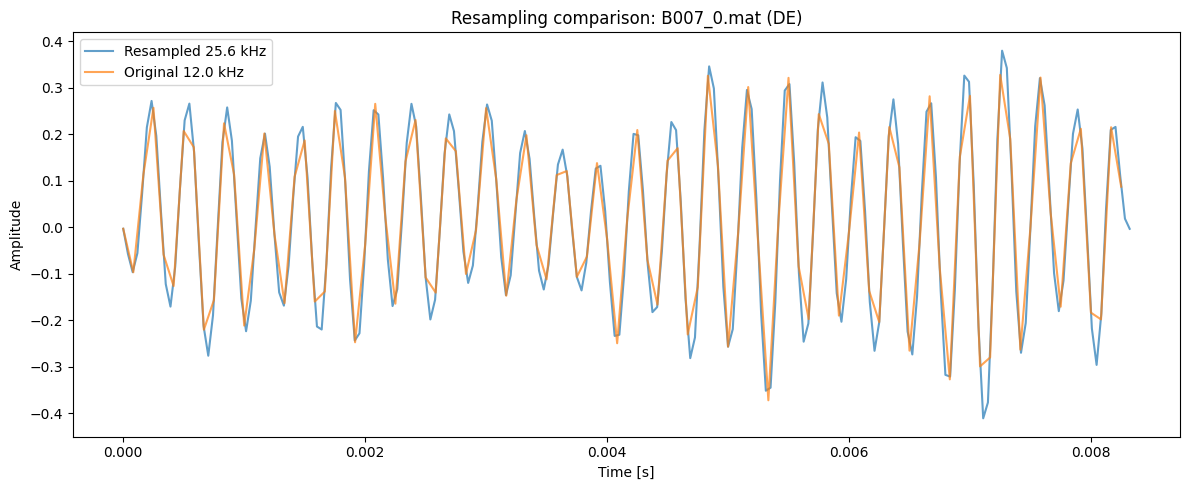

In [6]:
mat_path = "../../data/raw_cwru/vibration_mat_12kHz/B007_0.mat"
m_plot.compare_resampling(mat_path, channel="DE", max_len=100)

# Feature Extraction

In [ ]:
import numpy as np
from scipy.signal import hilbert
from scipy.fftpack import fft

def extract_features_dataset(
    data_dict,
    class_labels,
    window_size,
    stride=None,
    hilbert_channels=(0, 3),
    fixed_channels=None,
    auto_common=True
):
    """
    Returns:
      X: [segments, window_size//2, C] with consistent C across all samples
      y: [segments] integer class ids aligned to class_labels
      used_channels: list of channel indices used in X
      seg_meta: list of dicts with label and segment info
    """
    if stride is None:
        stride = window_size

    # Decide consistent channels
    if fixed_channels is not None:
        used_channels = list(fixed_channels)
    elif auto_common:
        # Use the minimum channel count across available arrays
        ch_counts = []
        for lbl in class_labels:
            if lbl in data_dict:
                arr = data_dict[lbl]
                if arr.ndim == 1:
                    arr = arr[:, None]
                ch_counts.append(arr.shape[1])
        if not ch_counts:
            raise ValueError("No arrays found for the provided class_labels")
        min_c = int(min(ch_counts))
        if min_c < 1:
            raise ValueError("Detected zero channels")
        used_channels = list(range(min_c))
    else:
        # Default to the first array shape
        first_lbl = next(lbl for lbl in class_labels if lbl in data_dict)
        first_arr = data_dict[first_lbl]
        if first_arr.ndim == 1:
            first_arr = first_arr[:, None]
        used_channels = list(range(first_arr.shape[1]))

    feats = []
    y_list = []
    seg_meta = []

    for cls_id, lbl in enumerate(class_labels):
        if lbl not in data_dict:
            continue
        arr = data_dict[lbl]
        if arr.ndim == 1:
            arr = arr[:, None]

        # If any requested channel is out of range, skip this label entirely
        if any(ch >= arr.shape[1] for ch in used_channels):
            # skip arrays lacking required channels
            continue

        x = arr[:, used_channels]  # enforce consistent channels
        n, c = x.shape
        if n < window_size:
            continue

        starts = np.arange(0, n - window_size + 1, stride, dtype=int)
        for s in starts:
            seg = x[s:s + window_size, :]  # [win, C]

            # Z score per channel
            mu = seg.mean(axis=0, keepdims=True)
            sd = seg.std(axis=0, keepdims=True)
            sd = np.where(sd == 0, 1e-8, sd)
            seg_z = (seg - mu) / sd

            # Hilbert envelope on selected channels if they exist
            seg_proc = seg_z.copy()
            for hch in hilbert_channels:
                if 0 <= hch < seg_proc.shape[1]:
                    seg_proc[:, hch] = np.abs(hilbert(seg_proc[:, hch]))

            # FFT magnitude positive half per channel
            spec = np.abs(fft(seg_proc, axis=0))[:window_size // 2, :]  # [bins, C]
            feats.append(spec.astype(np.float32))
            y_list.append(cls_id)
            seg_meta.append({
                "label": lbl,
                "start": int(s),
                "end": int(s + window_size),
                "channels_used": used_channels
            })

    if not feats:
        raise ValueError("No segments extracted. Check window_size, stride, and channels policy.")

    X = np.stack(feats, axis=0)  # [Nseg, bins, C] now consistent
    y = np.array(y_list, dtype=np.int64)
    return X, y, used_channels, seg_meta

# KAIST
X_kaist, y_kaist, ch_kaist, meta_kaist = extract_features_dataset(
    vibration_data_kaist_unified, class_labels_kaist_unified,
    window_size=5120, stride=5120, fixed_channels=[0]
)

class_labels_unified = ['Normal', 'BPFI', 'BPFO', 'Misalign', 'Unbalance', 'Ball']  # CWRU Dataset use this labels for Transfer Learning

# CWRU at 25.6 kHz after resampling
X_cwru, y_cwru, ch_cwru, meta_cwru = extract_features_dataset(
    vibration_data_cwru_unified, class_labels_unified,
    window_size=5120, stride=5120, fixed_channels=[0]
)

Summarize Features


[KAIST] Summary
  Shape X: (3300, 2560, 1)  y: (3300,)
  Channels: 1  Bins: 2560
  Stats  min:0.003  max:6521.695  mean:31.916
  NaN present: False  Inf present: False
  Samples per class:
   - Normal: 1500
   - BPFI: 300
   - BPFO: 300
   - Misalign: 600
   - Unbalance: 600
  Mean spectral energy per channel: [45748676.]


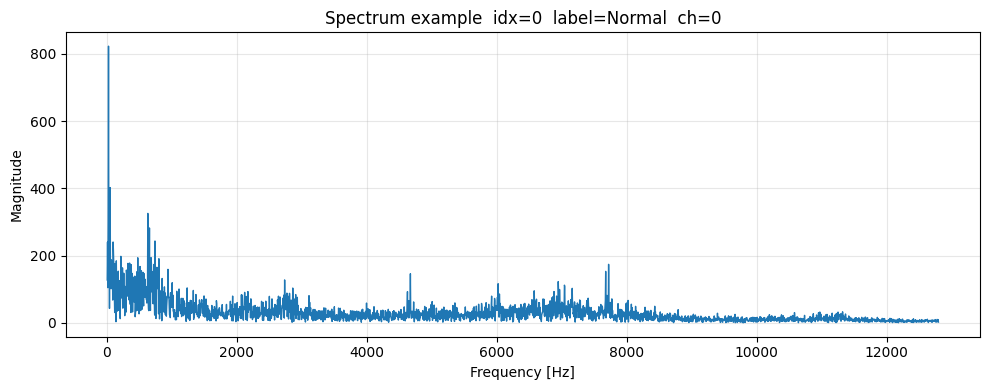

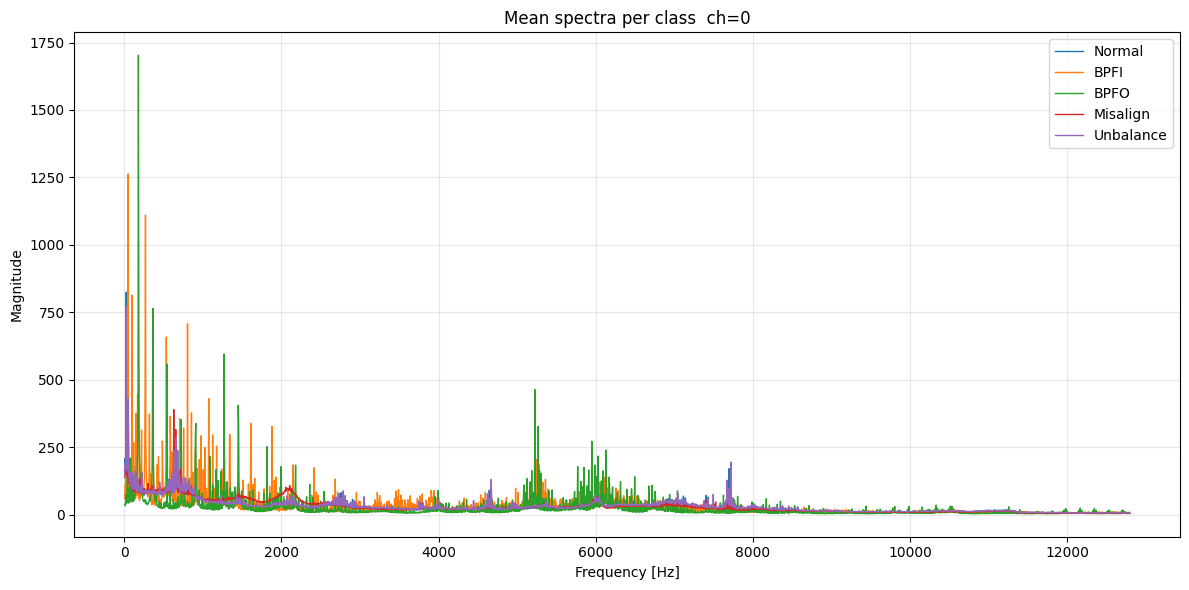


[CWRU] Summary
  Shape X: (354, 2560, 1)  y: (354,)
  Channels: 1  Bins: 2560
  Stats  min:0.001  max:6602.408  mean:18.555
  NaN present: False  Inf present: False
  Samples per class:
   - Normal: 101
   - BPFI: 50
   - BPFO: 152
   - Ball: 0
  Mean spectral energy per channel: [44021464.]


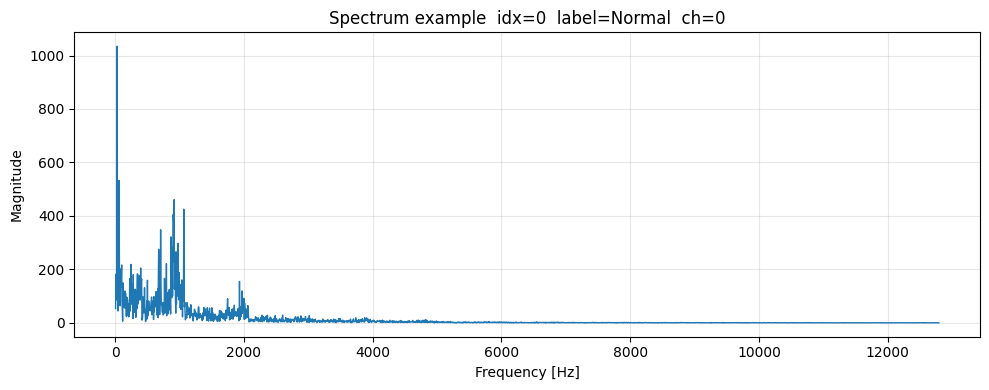

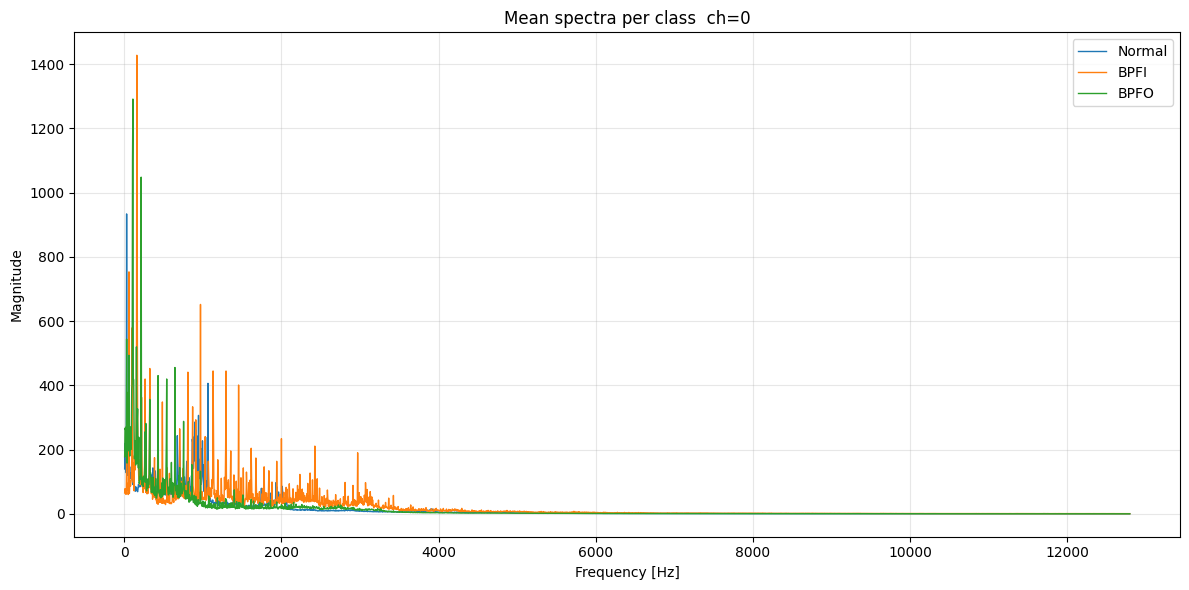

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def summarize_features(X, y, class_labels, name="dataset"):
    """
    Quick integrity report for feature tensors.
    X: [n_segments, n_bins, n_channels]
    y: [n_segments] integer ids aligned with class_labels
    """
    assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
    assert X.ndim == 3, f"X must be 3D [segments, bins, channels], got {X.shape}"
    assert y.ndim == 1, f"y must be 1D [segments], got {y.shape}"
    assert X.shape[0] == y.shape[0], "Segments count mismatch between X and y"

    # NaN or Inf check
    has_nan = np.isnan(X).any()
    has_inf = np.isinf(X).any()

    # Basic stats
    n_segments, n_bins, n_channels = X.shape
    value_min = float(np.nanmin(X))
    value_max = float(np.nanmax(X))
    value_mean = float(np.nanmean(X))

    # Label coverage
    cnt = Counter(y.tolist())
    label_rows = []
    for i, lbl in enumerate(class_labels):
        label_rows.append((lbl, cnt.get(i, 0)))

    print(f"\n[{name}] Summary")
    print(f"  Shape X: {X.shape}  y: {y.shape}")
    print(f"  Channels: {n_channels}  Bins: {n_bins}")
    print(f"  Stats  min:{value_min:.3f}  max:{value_max:.3f}  mean:{value_mean:.3f}")
    print(f"  NaN present: {has_nan}  Inf present: {has_inf}")
    print("  Samples per class:")
    for lbl, n in label_rows:
        print(f"   - {lbl}: {n}")

    # Simple per channel energy check
    energy = np.mean(np.sum(X**2, axis=1), axis=0)  # mean over segments of sum over bins per channel
    print("  Mean spectral energy per channel:", np.round(energy, 3))
    
def plot_feature_example(X, y, class_labels, fs, label=None, idx=None, channel=0):
    """
    Plot one feature vector: magnitude spectrum of a chosen segment and channel.
    If label is given chooses the first sample of that class. If idx is given uses that index.
    """
    n_segments, n_bins, n_channels = X.shape
    if channel >= n_channels:
        raise ValueError(f"channel {channel} out of range {n_channels}")

    if idx is None:
        if label is None:
            idx = 0
        else:
            cls_id = class_labels.index(label)
            where = np.where(y == cls_id)[0]
            if len(where) == 0:
                raise ValueError(f"No segments for label {label}")
            idx = int(where[0])
 
    freqs = np.fft.fftfreq(n_bins*2, d=1/fs)[:n_bins]  # consistent with window_size//2 bins
    spec = X[idx, 1:, channel]  # remove DC (first bin)
    freqs = freqs[1:]           # remove DC frequency

    plt.figure(figsize=(10,4))
    plt.plot(freqs, spec, lw=1)
    ttl_label = class_labels[y[idx]] if 0 <= y[idx] < len(class_labels) else f"id {y[idx]}"
    plt.title(f"Spectrum example  idx={idx}  label={ttl_label}  ch={channel}")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_class_mean_spectra(X, y, class_labels, fs, channel=0):
    """
    Plot mean spectrum per class for a chosen channel for a quick separability check.
    """
    n_segments, n_bins, n_channels = X.shape
    if channel >= n_channels:
        raise ValueError(f"channel {channel} out of range {n_channels}")
    freqs = np.fft.fftfreq(n_bins*2, d=1/fs)[:n_bins]
    freqs = freqs[1:]  # remove DC frequency

    plt.figure(figsize=(12,6))
    for cid, lbl in enumerate(class_labels):
        idxs = np.where(y == cid)[0]
        if len(idxs) == 0:
            continue
        mean_spec = X[idxs, 1:, channel].mean(axis=0)
        plt.plot(freqs, mean_spec, lw=1, label=lbl)
    plt.title(f"Mean spectra per class  ch={channel}")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# KAIST
summarize_features(X_kaist, y_kaist, class_labels_kaist_unified, name="KAIST")
plot_feature_example(X_kaist, y_kaist, class_labels_kaist_unified, fs=sampling_rate_kaist, label=class_labels_kaist_unified[0], channel=0)
plot_class_mean_spectra(X_kaist, y_kaist, class_labels_kaist_unified, fs=sampling_rate_kaist, channel=0)

# CWRU
summarize_features(X_cwru, y_cwru, class_labels_cwru_unified, name="CWRU")
plot_feature_example(X_cwru, y_cwru, class_labels_cwru_unified, fs=target_sampling_rate_cwru, label=class_labels_cwru_unified[0], channel=0)
plot_class_mean_spectra(X_cwru, y_cwru, class_labels_cwru_unified, fs=target_sampling_rate_cwru, channel=0)


Plot KAIST Feature Extraction

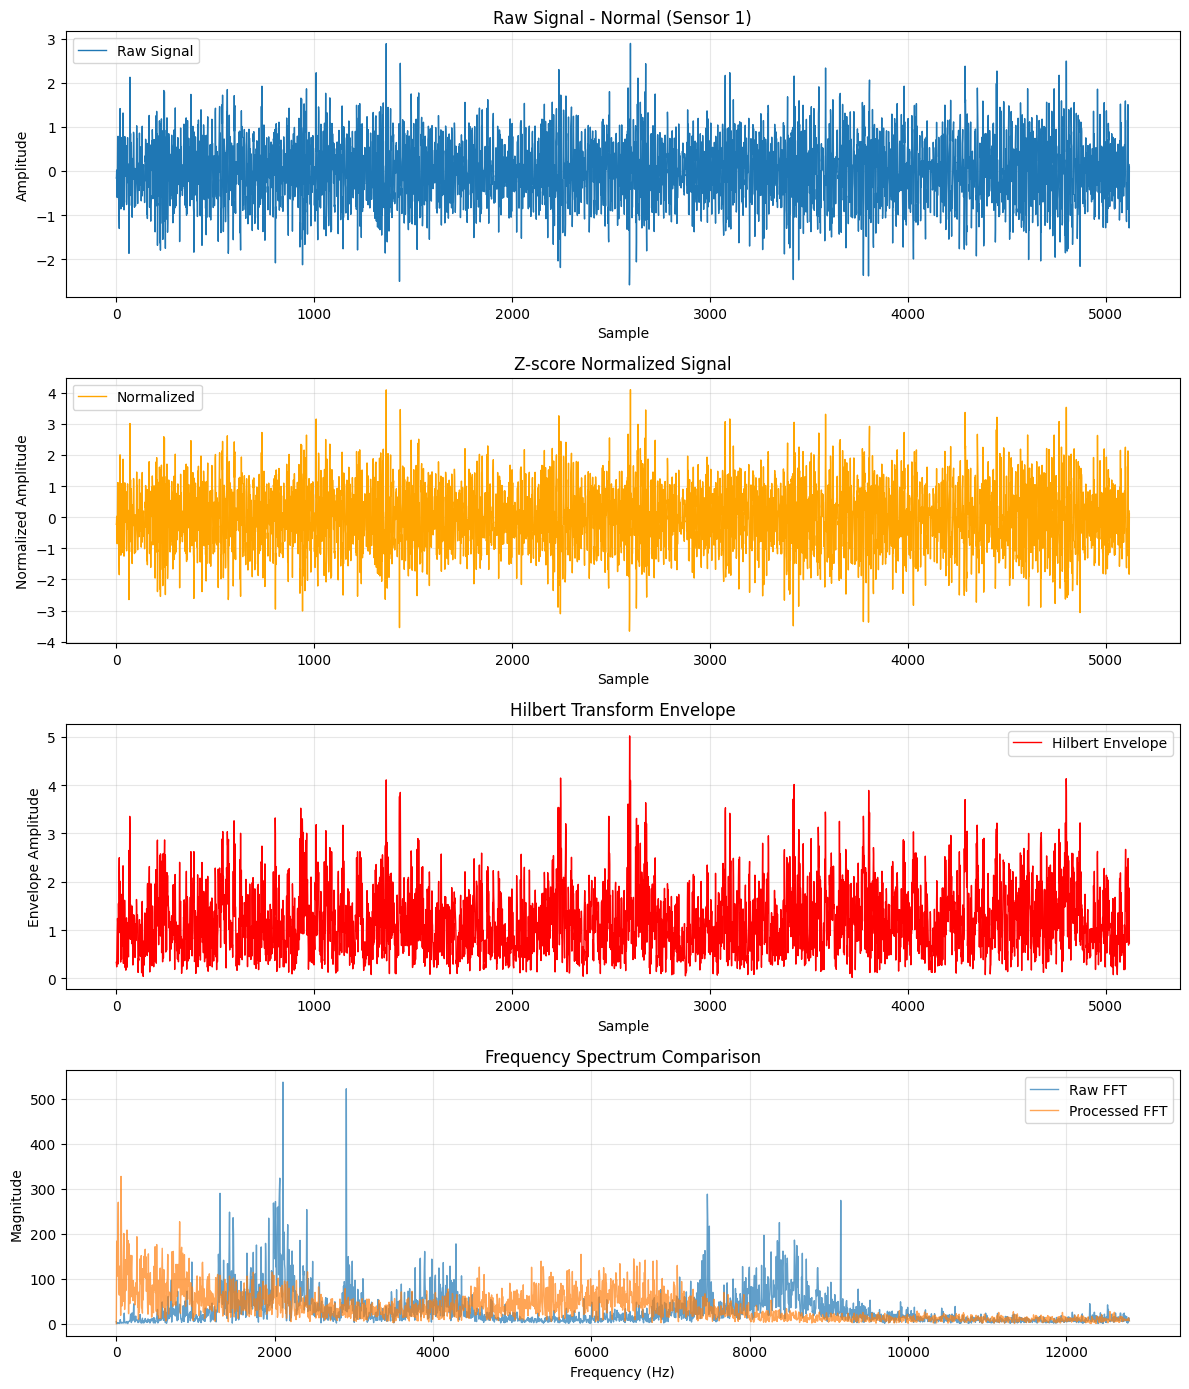

In [9]:
sampling_rate_unified = sampling_rate_kaist  # since both datasets are now at 25.6 kHz
m_plot.plot_signal_examples(vibration_data_kaist_unified, class_labels_kaist_unified, sampling_rate_unified, window_size=5120)

Plot CWRU Feature Extraction

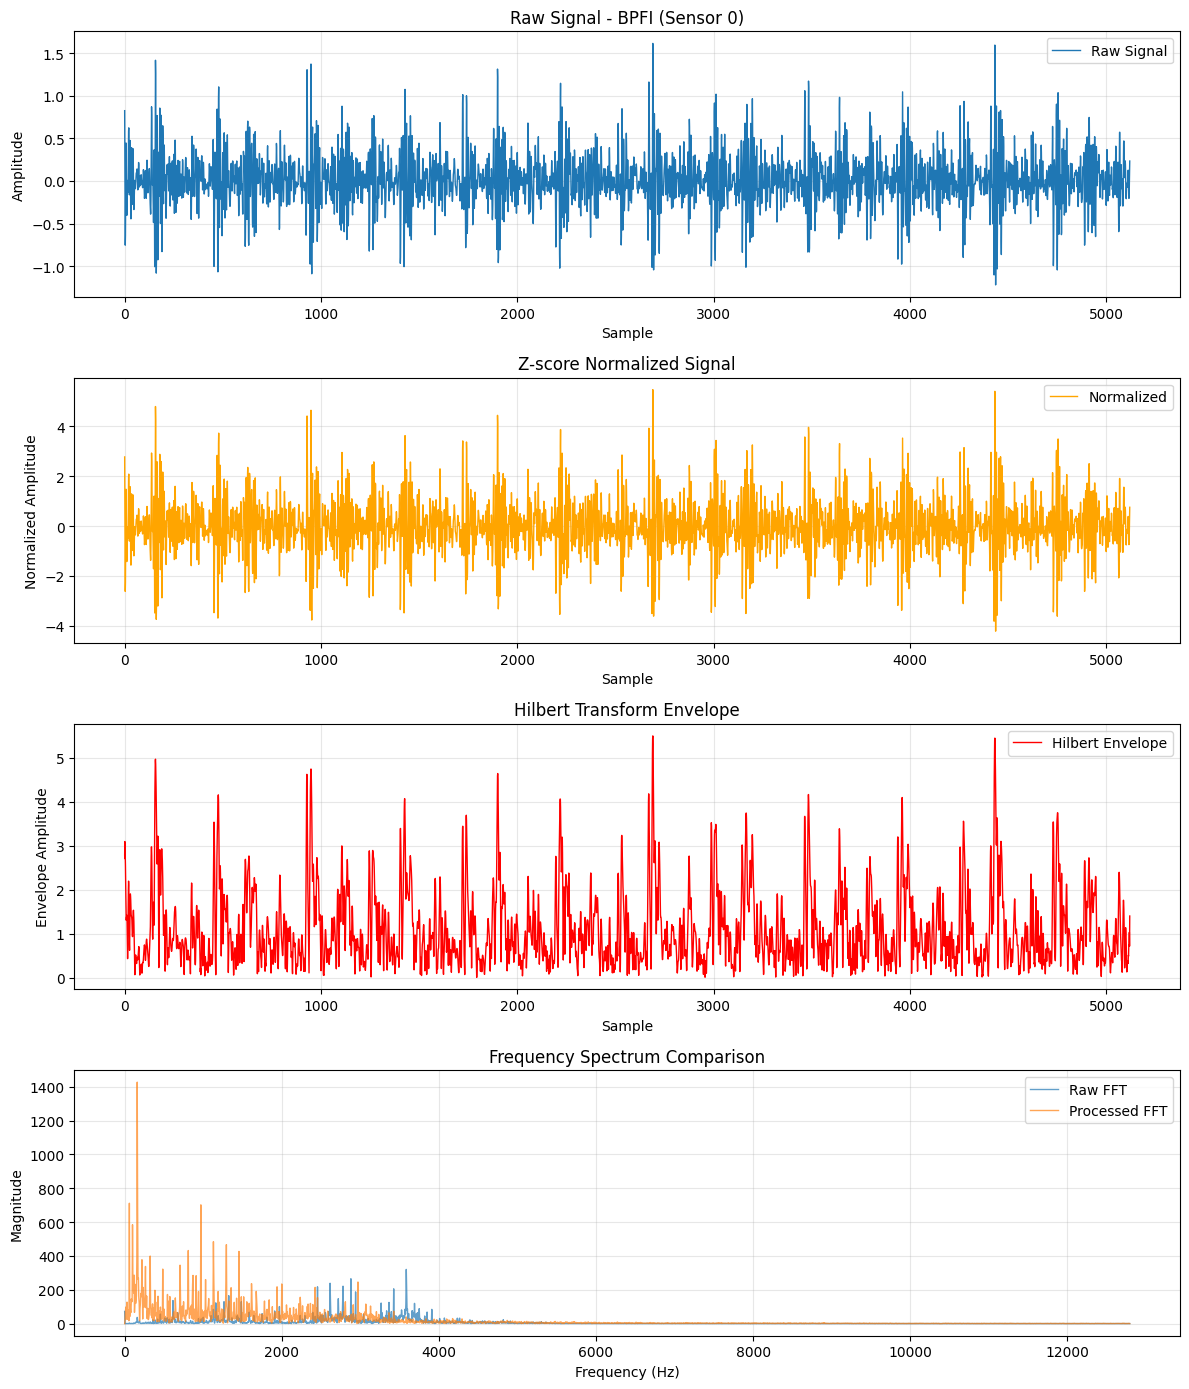

In [10]:
m_plot.plot_signal_examples(vibration_data_cwru_unified, class_labels_cwru_unified, sampling_rate_unified, window_size=5120)

# Model Definition

## Build Backbone model (KAIST)

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, MaxPooling1D, GlobalAveragePooling1D, Dense, Input

def build_model(input_shape, num_classes=5):
    model = Sequential([
        Input(shape=input_shape),

        # Conv Block 1
        Conv1D(filters=32, kernel_size=33, strides=6, padding='same',
               kernel_initializer='he_normal', use_bias=False),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=3, strides=3, padding='same'),

        # Conv Block 2
        Conv1D(filters=64, kernel_size=9, strides=3, padding='same',
               kernel_initializer='he_normal', use_bias=False),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=3, strides=3, padding='same'),

        # Conv Block 3
        Conv1D(filters=128, kernel_size=3, strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=False),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=2, strides=2, padding='same'),

        # Global average pooling over time
        GlobalAveragePooling1D(),

        # Dense head
        Dense(100, activation='relu'),
        Dense(num_classes, activation='softmax'),
    ])
    return model



In [12]:
from sklearn.model_selection import KFold
import seaborn as sns

# 1) Build KAIST features with one channel
X, y_int, used_ch, meta = X_kaist, y_kaist, ch_kaist, meta_kaist

X = X.astype("float32")                 # [N, 2560, 1]
Y = tf.keras.utils.to_categorical(y_int, num_classes=len(class_labels_kaist_unified))

# 2) Define input shape directly from X
input_shape = (X.shape[1], X.shape[2])  # (2560, 1)

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

save_dir = '../models_kaist0'

os.makedirs(save_dir, exist_ok=True)
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

all_reports = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    print(f"\nFold {fold}/{k}")

    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]

    model = build_model(input_shape, num_classes=len(class_labels_kaist_unified))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
        ModelCheckpoint(os.path.join(save_dir, f"kaist_model0_fold_{fold}.keras"),
                        monitor="val_accuracy", save_best_only=True)
    ]

    model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2,
              validation_data=(X_test, Y_test), callbacks=callbacks)

    # Predict and evaluate
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(Y_test, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

    # Plot confusion matrix with class numbers
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=np.arange(len(class_labels_kaist_unified)),  # numbers on axes
                yticklabels=np.arange(len(class_labels_kaist_unified)))

    plt.xlabel("Predicted (class number)")
    plt.ylabel("Actual (class number)")
    plt.title(f"Confusion Matrix (Fold {fold})")

    # Add legend mapping numbers to classes
    handles = [plt.Rectangle((0,0),1,1, color="white", ec="white", alpha=0)] * len(class_labels_kaist_unified)
    labels = [f"{i}: {cls}" for i, cls in enumerate(class_labels_kaist_unified)]
    plt.legend(handles, labels, title="Class mapping",
            bbox_to_anchor=(1.3, 1), loc="upper left")

    cm_filename = os.path.join(save_dir, f"confusion_matrix_fold_{fold}.png")
    plt.savefig(cm_filename, bbox_inches="tight")
    plt.close()
    print(f"Saved confusion matrix for fold {fold} at {cm_filename}")

    # Per fold report
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    all_reports.append(rep)

    rep_df = pd.DataFrame(rep).transpose()
    rep_path = os.path.join(save_dir, f"classification_report_fold_{fold}.csv")
    rep_df.to_csv(rep_path)
    print(f"Saved classification report for fold {fold} at {rep_path}")

# ---------- Aggregate reports: mean ± std ----------
# Convert nested dicts to DataFrames and keep numeric columns
report_dfs = []
for rep in all_reports:
    df = pd.DataFrame(rep).transpose()
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    report_dfs.append(df)

metrics = ["precision", "recall", "f1-score"]
labels = report_dfs[0].index.tolist()

metric_stack = {m: np.stack([df[m].values for df in report_dfs], axis=0) for m in metrics}
support_stack = np.stack([df["support"].values for df in report_dfs], axis=0)

rows = []
for i, lab in enumerate(labels):
    row = []
    for m in metrics:
        vals = metric_stack[m][:, i]
        mean = np.nanmean(vals)
        std = np.nanstd(vals)
        row.append(f"{mean:.4f} ± {std:.4f}")
    row.append(int(np.nanmean(support_stack[:, i])))
    rows.append(row)

final_report_df = pd.DataFrame(rows,
                               columns=["Precision", "Recall", "F1-score", "Support"],
                               index=labels)

final_csv = os.path.join(save_dir, "final_averaged_report.csv")
final_report_df.to_csv(final_csv)
print(f"Final Averaged Report saved at {final_csv}")

# Optional: render the final table as an image
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis("off")
tbl = ax.table(cellText=final_report_df.values,
               colLabels=final_report_df.columns,
               rowLabels=final_report_df.index,
               cellLoc="center", loc="center")
plt.savefig(os.path.join(save_dir, "final_report_table.png"),
            bbox_inches="tight", dpi=300)
plt.close()



Fold 1/5
Epoch 1/100
83/83 - 3s - 34ms/step - accuracy: 0.8167 - loss: 0.4853 - val_accuracy: 0.9333 - val_loss: 0.2871
Epoch 2/100
83/83 - 1s - 10ms/step - accuracy: 0.9659 - loss: 0.1036 - val_accuracy: 0.8015 - val_loss: 0.5029
Epoch 3/100
83/83 - 1s - 10ms/step - accuracy: 0.9799 - loss: 0.0558 - val_accuracy: 0.9515 - val_loss: 0.1243
Epoch 4/100
83/83 - 1s - 11ms/step - accuracy: 0.9913 - loss: 0.0307 - val_accuracy: 0.9697 - val_loss: 0.0687
Epoch 5/100
83/83 - 1s - 11ms/step - accuracy: 0.9951 - loss: 0.0185 - val_accuracy: 0.9879 - val_loss: 0.0362
Epoch 6/100
83/83 - 1s - 10ms/step - accuracy: 0.9989 - loss: 0.0090 - val_accuracy: 0.9288 - val_loss: 0.1930
Epoch 7/100
83/83 - 1s - 10ms/step - accuracy: 0.9943 - loss: 0.0178 - val_accuracy: 0.9561 - val_loss: 0.1267
Epoch 8/100
83/83 - 1s - 10ms/step - accuracy: 0.9924 - loss: 0.0212 - val_accuracy: 0.9773 - val_loss: 0.0515
Epoch 9/100
83/83 - 1s - 10ms/step - accuracy: 0.9989 - loss: 0.0055 - val_accuracy: 0.9515 - val_loss

## Transfer Learning with Few Shots

### Data Prep for Transfer

In [6]:
# KAIST
Xk = X_kaist.astype("float32")              # (3300, 2560, 1)
yk = y_kaist.astype("int32")                # (3300,)

# CWRU
Xc = X_cwru.astype("float32")               # (354, 2560, 1)
yc = y_cwru.astype("int32")                 # (354,)

assert Xk.shape[1:] == (2560, 1)
assert Xc.shape[1:] == (2560, 1)

assert yk.min() >= 0 and yk.max() <= 4
assert yc.min() >= 0 and yc.max() <= 5


In [35]:
# Batch sizes
BATCH_CWRU = 16   # try 8, 16, 32
BATCH_KAIST = 64  # try 32, 64, 128

AUTOTUNE = tf.data.AUTOTUNE

# Base domain datasets
ds_kaist = tf.data.Dataset.from_tensor_slices((Xk, yk)) \
    .shuffle(min(len(Xk), 10000), seed=42, reshuffle_each_iteration=True) \
    .batch(BATCH_KAIST).prefetch(AUTOTUNE)

ds_cwru_single = tf.data.Dataset.from_tensor_slices((Xc, yc)) \
    .shuffle(min(len(Xc), 1000), seed=42, reshuffle_each_iteration=True)

# Oversample Ball inside CWRU
ball_id = tf.constant(5, dtype=tf.int32)
ds_cwru_ball  = ds_cwru_single.filter(lambda x, y: tf.equal(y, ball_id))
ds_cwru_other = ds_cwru_single.filter(lambda x, y: tf.not_equal(y, ball_id))

# 0.5 Ball 0.5 others; if needed push Ball to 0.6
ds_cwru_bal_single = tf.data.Dataset.sample_from_datasets(
    [ds_cwru_ball, ds_cwru_other], weights=[0.5, 0.5], seed=42
)
ds_cwru_bal = ds_cwru_bal_single.batch(BATCH_CWRU).prefetch(AUTOTUNE)

# Mixed datasets with tunable weights
W_CWRU_A = 0.8  # Stage A, try 0.7 to 0.9
W_CWRU_B = 0.5  # Stage B, try 0.4 to 0.6

ds_mixed_headonly = tf.data.Dataset.sample_from_datasets(
    [ds_cwru_bal, ds_kaist], weights=[W_CWRU_A, 1.0 - W_CWRU_A], seed=42
).prefetch(AUTOTUNE)

ds_cwru_batched = ds_cwru_single.batch(BATCH_CWRU).prefetch(AUTOTUNE)
ds_mixed_finetune = tf.data.Dataset.sample_from_datasets(
    [ds_cwru_batched, ds_kaist], weights=[W_CWRU_B, 1.0 - W_CWRU_B], seed=42
).prefetch(AUTOTUNE)


### Model


In [36]:
import tensorflow as tf

# Load the KAIST model
base = tf.keras.models.load_model("../models_kaist0/kaist_model0_fold_1.keras")

# Inspect
base.summary()  # your tail is GAP -> dense(100) -> dense_1(5)

# Create a new Sequential that reuses all backbone layers except the last classifier
modelTransfer = tf.keras.Sequential(name="transfer_kaist_cwru")

# Add backbone layers up to and including the 100 unit Dense named "dense"
for layer in base.layers[:-1]:   # drops the last Dense(5)
    modelTransfer.add(layer)

# Add a new 6 class head
modelTransfer.add(tf.keras.layers.Dense(6, activation="softmax", name="cls6"))

# Build once to define inputs
_ = modelTransfer(tf.zeros((1, 2560, 1), dtype=tf.float32))

# Step A. Freeze the backbone. Allow BN to update statistics if you want.
for l in modelTransfer.layers[:-1]:   # exclude the new head
    l.trainable = False
for l in modelTransfer.layers[:-1]:
    if isinstance(l, tf.keras.layers.BatchNormalization):
        l.trainable = True

# Compile for sparse integer labels
modelTransfer.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"]
                      )

# Train on the mixed dataset that oversamples Ball
history_a = modelTransfer.fit(ds_mixed_headonly, epochs=30, verbose=2)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 427, 32)        │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 427, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 427, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 143, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 48, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 16, 128)        │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,201 (680.48 KB)

 Trainable params: 57,917 (226.24 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 115,836 (452.49 KB)

Epoch 1/30
75/75 - 2s - 27ms/step - accuracy: 0.3142 - loss: 2.2102
Epoch 2/30


w:\Git\flex-uns-fw\.venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 - 1s - 8ms/step - accuracy: 0.9247 - loss: 0.5019
Epoch 3/30
75/75 - 1s - 8ms/step - accuracy: 0.9360 - loss: 0.3488
Epoch 4/30
75/75 - 1s - 8ms/step - accuracy: 0.9491 - loss: 0.2815
Epoch 5/30
75/75 - 1s - 9ms/step - accuracy: 0.9559 - loss: 0.2447
Epoch 6/30
75/75 - 1s - 8ms/step - accuracy: 0.9614 - loss: 0.2066
Epoch 7/30
75/75 - 1s - 8ms/step - accuracy: 0.9663 - loss: 0.1811
Epoch 8/30
75/75 - 1s - 8ms/step - accuracy: 0.9704 - loss: 0.1624
Epoch 9/30
75/75 - 1s - 8ms/step - accuracy: 0.9743 - loss: 0.1441
Epoch 10/30
75/75 - 1s - 8ms/step - accuracy: 0.9778 - loss: 0.1252
Epoch 11/30
75/75 - 1s - 9ms/step - accuracy: 0.9803 - loss: 0.1108
Epoch 12/30
75/75 - 1s - 8ms/step - accuracy: 0.9814 - loss: 0.0958
Epoch 13/30
75/75 - 1s - 9ms/step - accuracy: 0.9833 - loss: 0.0916
Epoch 14/30
75/75 - 1s - 8ms/step - accuracy: 0.9847 - loss: 0.0811
Epoch 15/30
75/75 - 1s - 9ms/step - accuracy: 0.9858 - loss: 0.0755
Epoch 16/30
75/75 - 1s - 8ms/step - accuracy: 0.9839 - loss: 0.0751

In [37]:
# Pick a small set of tail layer names to unfreeze
names_to_unfreeze = [
    "conv1d_2", "batch_normalization_2", "re_lu_2", "max_pooling1d_2",
    "global_average_pooling1d", "dense"   # the original Dense(100)
]

for l in modelTransfer.layers:
    if l.name in names_to_unfreeze:
        l.trainable = True

modelTransfer.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])

history_b = modelTransfer.fit(ds_mixed_finetune, epochs=20, verbose=2)

modelTransfer.save("multi_dataset-kaist+cwru.keras")


Epoch 1/20
75/75 - 2s - 29ms/step - accuracy: 0.9964 - loss: 0.0184
Epoch 2/20
75/75 - 1s - 9ms/step - accuracy: 0.9986 - loss: 0.0107
Epoch 3/20
75/75 - 1s - 8ms/step - accuracy: 0.9978 - loss: 0.0081
Epoch 4/20
75/75 - 1s - 8ms/step - accuracy: 0.9989 - loss: 0.0068
Epoch 5/20
75/75 - 1s - 8ms/step - accuracy: 0.9984 - loss: 0.0075
Epoch 6/20
75/75 - 1s - 8ms/step - accuracy: 0.9986 - loss: 0.0089
Epoch 7/20
75/75 - 1s - 8ms/step - accuracy: 0.9989 - loss: 0.0057
Epoch 8/20
75/75 - 1s - 9ms/step - accuracy: 0.9992 - loss: 0.0040
Epoch 9/20
75/75 - 1s - 8ms/step - accuracy: 1.0000 - loss: 0.0028
Epoch 10/20
75/75 - 1s - 8ms/step - accuracy: 0.9992 - loss: 0.0069
Epoch 11/20
75/75 - 1s - 8ms/step - accuracy: 0.9973 - loss: 0.0106
Epoch 12/20
75/75 - 1s - 8ms/step - accuracy: 0.9978 - loss: 0.0120
Epoch 13/20
75/75 - 1s - 8ms/step - accuracy: 0.9995 - loss: 0.0040
Epoch 14/20
75/75 - 1s - 8ms/step - accuracy: 0.9997 - loss: 0.0036
Epoch 15/20
75/75 - 1s - 8ms/step - accuracy: 0.9995 - l

In [38]:
# 1) verify ids present in test
print("y_true counts:", np.bincount(y_true, minlength=6))
print("y_pred counts:", np.bincount(y_pred, minlength=6))

# 2) quick check: average logits per true class to see which neuron lights up
probs = modelTransfer.predict(Xc, verbose=0)
for c in range(6):
    idx = np.where(y_true == c)[0]
    if len(idx):
        print(c, "→ avg probs:", probs[idx].mean(axis=0).round(3))


y_true counts: [101  50 152   0   0  51]
y_pred counts: [101  50 152   1   0  50]
0 → avg probs: [0.993 0.    0.001 0.006 0.    0.   ]
1 → avg probs: [0.    0.893 0.002 0.105 0.    0.   ]
2 → avg probs: [0. 0. 1. 0. 0. 0.]
5 → avg probs: [0.017 0.001 0.011 0.542 0.    0.428]


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Ensure predictions
def report_transfer_results(modelTransfer, X, y, dataset, save_folder="./transfer"):
    """
    Generates and saves confusion matrix and classification report for transfer learning results.
    """
    os.makedirs(save_folder, exist_ok=True)
    # Predictions
    probs = modelTransfer.predict(X, verbose=0)
    y_pred = np.argmax(probs, axis=1)
    y_true = y.astype(int)

    class_labels = ['Normal','BPFI','BPFO','Misalign','Unbalance','Ball']
    labels_all = np.arange(len(class_labels))  # [0..5]

    # Confusion matrix with fixed label set
    cm = confusion_matrix(y_true, y_pred, labels=labels_all)

    # Row percentage with safe divide
    row_sums = cm.sum(axis=1, keepdims=True)
    cm_pct = np.divide(cm, np.maximum(row_sums, 1), where=row_sums>0) * 100.0

    plt.figure(figsize=(6,4))
    sns.heatmap(cm_pct, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=np.arange(len(class_labels)),
                yticklabels=np.arange(len(class_labels)))
    plt.xlabel("Predicted class number")
    plt.ylabel("Actual class number")
    plt.title(f"Confusion Matrix Transfer - {dataset}")
    legend = [f"{i}: {cls}" for i, cls in enumerate(class_labels)]
    plt.gcf().text(1.02, 0.5, "\n".join(legend), va="center", fontsize=8)
    plt.savefig(f"{save_folder}/transfer_confusion_matrix.png", bbox_inches="tight", dpi=300)
    plt.close()

    # Classification report fixed label set
    rep = classification_report(
        y_true, y_pred,
        labels=labels_all,
        target_names=class_labels,
        output_dict=True,
        zero_division=0
    )
    rep_df = pd.DataFrame(rep).transpose()
    rep_df.to_csv(f"{save_folder}/transfer_classification_report.csv", float_format="%.6f")

    # Render table image
    fig, ax = plt.subplots(figsize=(10,5))
    ax.axis("off")
    tbl = ax.table(
        cellText=rep_df.round(4).values,
        colLabels=rep_df.columns,
        rowLabels=rep_df.index,
        cellLoc="center", loc="center"
    )
    plt.savefig(f"{save_folder}/transfer_report_table.png", bbox_inches="tight", dpi=300)
    plt.close()


    print(f"Saved {save_folder}/transfer_confusion_matrix.png, {save_folder}/transfer_classification_report.csv")

report_transfer_results(modelTransfer, Xc, yc, "CWRU",save_folder="./cwru_test2")
report_transfer_results(modelTransfer, Xk, yk, "KAIST", save_folder="./kaist_test2")


Saved ./cwru_test2/transfer_confusion_matrix.png, ./cwru_test2/transfer_classification_report.csv
Saved ./kaist_test2/transfer_confusion_matrix.png, ./kaist_test2/transfer_classification_report.csv


In [47]:
# Step 1 — Mixed BN recalibration (no gradients)
import tensorflow as tf
import numpy as np

BATCH_KAIST = 64
BATCH_CWRU  = 16
AUTOTUNE = tf.data.AUTOTUNE

# Build simple domain loaders
ds_k_bn = tf.data.Dataset.from_tensor_slices((Xk, yk)) \
    .shuffle(min(len(Xk), 10000), seed=42, reshuffle_each_iteration=True) \
    .batch(BATCH_KAIST).prefetch(AUTOTUNE)

ds_c_bn = tf.data.Dataset.from_tensor_slices((Xc, yc)) \
    .shuffle(min(len(Xc), 1000), seed=42, reshuffle_each_iteration=True) \
    .batch(BATCH_CWRU).prefetch(AUTOTUNE)

# Equal mix so stats do not drift to a single domain
ds_bn_mixed = tf.data.Dataset.sample_from_datasets(
    [ds_k_bn, ds_c_bn], weights=[0.5, 0.5], seed=42
).prefetch(AUTOTUNE)

# Enable only BN stats update
for l in modelTransfer.layers:
    l.trainable = False
for l in modelTransfer.layers:
    if isinstance(l, tf.keras.layers.BatchNormalization):
        l.trainable = True

# One mixed pass with training=True so BN updates running means/vars
for xb, yb in ds_bn_mixed:
    _ = modelTransfer(xb, training=True)

# Freeze BN again
for l in modelTransfer.layers:
    if isinstance(l, tf.keras.layers.BatchNormalization):
        l.trainable = False


In [51]:
import numpy as np
import tensorflow as tf

# 0) Build the graph once so tensors exist
_ = modelTransfer(tf.zeros((1, 2560, 1), dtype=tf.float32))

# 1) Freeze backbone and keep BN frozen
for l in modelTransfer.layers[:-1]:
    l.trainable = False
for l in modelTransfer.layers:
    if isinstance(l, tf.keras.layers.BatchNormalization):
        l.trainable = False

# 2) Feature extractor: from first layer's input to the penultimate layer's output
feature_model = tf.keras.Model(
    inputs=modelTransfer.layers[0].input,
    outputs=modelTransfer.layers[-2].output   # the Dense(100) output
)

# 3) Collect features: all CWRU (to represent Ball) + a KAIST slice
rng = np.random.RandomState(42)
take_k = min(1200, len(Xk))
idx_k = rng.choice(len(Xk), size=take_k, replace=False)

F_k = feature_model.predict(Xk[idx_k], verbose=0)
L_k = yk[idx_k].astype(int)

F_c = feature_model.predict(Xc, verbose=0)
L_c = yc.astype(int)

F = np.concatenate([F_k, F_c], axis=0)  # shape [M, 100]
L = np.concatenate([L_k, L_c], axis=0)  # ints 0..5

# 4) Compute per class prototypes
protos = []
for c in range(6):
    idx = np.where(L == c)[0]
    if len(idx) == 0:
        proto = np.random.normal(scale=0.01, size=F.shape[1])
    else:
        take = min(256, len(idx))
        proto = F[idx[:take]].mean(axis=0)
    proto = proto / (np.linalg.norm(proto) + 1e-8)
    protos.append(proto)

P = np.stack(protos, axis=1).astype("float32")  # shape [100, 6]

# 5) Assign prototypes to the last Dense (kernel) and zero bias
last = modelTransfer.layers[-1]  # Dense(6)
last.kernel.assign(P)
last.bias.assign(np.zeros((6,), dtype="float32"))

# 6) Quick check on CWRU
probs = modelTransfer.predict(Xc, verbose=0)
y_pred = probs.argmax(axis=1)
print("CWRU counts true:", np.bincount(yc, minlength=6))
print("CWRU counts pred:", np.bincount(y_pred, minlength=6))


CWRU counts true: [101  50 152   0   0  51]
CWRU counts pred: [  0   7 159   0   0 188]


In [54]:
import numpy as np
import tensorflow as tf

# Ensure the graph is built
_ = modelTransfer(tf.zeros((1, 2560, 1), dtype=tf.float32))

# Freeze backbone and BN
for l in modelTransfer.layers[:-1]:
    l.trainable = False
for l in modelTransfer.layers:
    if isinstance(l, tf.keras.layers.BatchNormalization):
        l.trainable = False

# Feature extractor up to the penultimate Dense(100)
feature_model = tf.keras.Model(
    inputs=modelTransfer.layers[0].input,
    outputs=modelTransfer.layers[-2].output
)

# Compute features for KAIST and CWRU
rng = np.random.RandomState(42)

# KAIST per class samples
F_k = feature_model.predict(Xk, verbose=0)
L_k = yk.astype(int)

# CWRU Ball only
F_c = feature_model.predict(Xc, verbose=0)
L_c = yc.astype(int)

# Build prototypes
num_feats = F_k.shape[1]
protos = []
max_per_class = 512  # limit per class to avoid bias

for c in range(6):
    if c == 5:
        idx = np.where(L_c == 5)[0]  # Ball from CWRU
        take = min(max_per_class, len(idx))
        if take == 0:
            proto = np.random.normal(scale=0.01, size=num_feats)
        else:
            proto = F_c[idx[:take]].mean(axis=0)
    else:
        idx = np.where(L_k == c)[0]   # classes 0..4 from KAIST
        take = min(max_per_class, len(idx))
        if take == 0:
            proto = np.random.normal(scale=0.01, size=num_feats)
        else:
            proto = F_k[idx[:take]].mean(axis=0)

    proto = proto / (np.linalg.norm(proto) + 1e-8)
    protos.append(proto)

P = np.stack(protos, axis=1).astype("float32")  # shape [100, 6]

# Assign to last Dense
last = modelTransfer.layers[-1]  # Dense(6)
last.kernel.assign(P)
last.bias.assign(np.zeros((6,), dtype="float32"))

# Quick checks
probs_c = modelTransfer.predict(Xc, verbose=0)
yp_c = probs_c.argmax(axis=1)
print("CWRU counts true:", np.bincount(yc, minlength=6))
print("CWRU counts pred:", np.bincount(yp_c, minlength=6))

probs_k = modelTransfer.predict(Xk, verbose=0)
yp_k = probs_k.argmax(axis=1)
print("KAIST counts true:", np.bincount(yk, minlength=6))
print("KAIST counts pred:", np.bincount(yp_k, minlength=6))


CWRU counts true: [101  50 152   0   0  51]
CWRU counts pred: [  0   0  66   0   0 288]
KAIST counts true: [1500  300  300  600  600    0]
KAIST counts pred: [1492  300  300  600  608    0]


In [55]:
import tensorflow as tf

# 0) Freeze everything except the last Dense head
for l in modelTransfer.layers:
    l.trainable = False
modelTransfer.layers[-1].trainable = True   # Dense(6)

# keep all BatchNorm frozen
for l in modelTransfer.layers:
    if isinstance(l, tf.keras.layers.BatchNormalization):
        l.trainable = False

# 1) Build the balanced mixed dataset
BATCH_CWRU = 16
BATCH_KAIST = 64
AUTOTUNE = tf.data.AUTOTUNE

# KAIST stream
ds_k = tf.data.Dataset.from_tensor_slices((Xk, yk)) \
    .shuffle(min(len(Xk), 10000), seed=42, reshuffle_each_iteration=True) \
    .batch(BATCH_KAIST).prefetch(AUTOTUNE)

# CWRU stream with Ball at 0.5 (not > 0.5 to avoid collapse)
ds_c_single = tf.data.Dataset.from_tensor_slices((Xc, yc)) \
    .shuffle(min(len(Xc), 1000), seed=42, reshuffle_each_iteration=True)
ds_c_ball  = ds_c_single.filter(lambda x,y: tf.equal(y, 5))
ds_c_other = ds_c_single.filter(lambda x,y: tf.not_equal(y, 5))
ds_c_bal   = tf.data.Dataset.sample_from_datasets(
    [ds_c_ball, ds_c_other], weights=[0.5, 0.5], seed=42
).batch(BATCH_CWRU).prefetch(AUTOTUNE)

# Mixed iterator: slightly favor CWRU, but not too much
W_CWRU = 0.7   # was too high before; this avoids overfitting the Ball logit
ds_mixed = tf.data.Dataset.sample_from_datasets(
    [ds_c_bal, ds_k], weights=[W_CWRU, 1.0 - W_CWRU], seed=42
).prefetch(AUTOTUNE)

# 2) Compile small LR, no label smoothing (your TF version), add mild weight decay
opt = tf.keras.optimizers.Adam(learning_rate=4e-4)
modelTransfer.compile(optimizer=opt,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics=["accuracy"])

# 3) Use modest class weight for Ball (not too large to avoid collapse)
class_weight = {5: 2.0}

# 4) Short head-only training with early stopping on training loss
cb_es = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=4, restore_best_weights=True)

history_head = modelTransfer.fit(ds_mixed,
                                 epochs=8,
                                 class_weight=class_weight,
                                 callbacks=[cb_es],
                                 verbose=2)

# 5) Quick recheck
probs_c = modelTransfer.predict(Xc, verbose=0)
yp_c = probs_c.argmax(axis=1)
print("CWRU counts true:", np.bincount(yc, minlength=6))
print("CWRU counts pred:", np.bincount(yp_c, minlength=6))

probs_k = modelTransfer.predict(Xk, verbose=0)
yp_k = probs_k.argmax(axis=1)
print("KAIST counts true:", np.bincount(yk, minlength=6))
print("KAIST counts pred:", np.bincount(yp_k, minlength=6))


Epoch 1/8
75/75 - 1s - 15ms/step - accuracy: 0.9469 - loss: 0.2492
Epoch 2/8
75/75 - 0s - 5ms/step - accuracy: 0.9808 - loss: 0.1643
Epoch 3/8
75/75 - 0s - 5ms/step - accuracy: 0.9953 - loss: 0.1279
Epoch 4/8
75/75 - 0s - 5ms/step - accuracy: 0.9978 - loss: 0.1072
Epoch 5/8
75/75 - 0s - 5ms/step - accuracy: 0.9978 - loss: 0.0910
Epoch 6/8
75/75 - 0s - 5ms/step - accuracy: 0.9986 - loss: 0.0788
Epoch 7/8
75/75 - 0s - 5ms/step - accuracy: 0.9986 - loss: 0.0694
Epoch 8/8
75/75 - 0s - 6ms/step - accuracy: 0.9992 - loss: 0.0623
CWRU counts true: [101  50 152   0   0  51]
CWRU counts pred: [101  50 152   0   0  51]
KAIST counts true: [1500  300  300  600  600    0]
KAIST counts pred: [1494  300  300  600  606    0]


In [56]:
import tensorflow as tf
import json
import numpy as np

# Build a small mixed loader (same as before)
BATCH_KAIST = 64
BATCH_CWRU  = 16
AUTOTUNE = tf.data.AUTOTUNE

ds_k_bn = tf.data.Dataset.from_tensor_slices((Xk, yk)) \
    .shuffle(min(len(Xk), 10000), seed=42, reshuffle_each_iteration=True) \
    .batch(BATCH_KAIST).prefetch(AUTOTUNE)

ds_c_bn = tf.data.Dataset.from_tensor_slices((Xc, yc)) \
    .shuffle(min(len(Xc), 1000), seed=42, reshuffle_each_iteration=True) \
    .batch(BATCH_CWRU).prefetch(AUTOTUNE)

ds_bn_mixed = tf.data.Dataset.sample_from_datasets(
    [ds_k_bn, ds_c_bn], weights=[0.5, 0.5], seed=42
).prefetch(AUTOTUNE)

# Enable only BN to update stats
for l in modelTransfer.layers:
    l.trainable = False
for l in modelTransfer.layers:
    if isinstance(l, tf.keras.layers.BatchNormalization):
        l.trainable = True

# One pass with training=True to update BN moving averages
for xb, yb in ds_bn_mixed:
    _ = modelTransfer(xb, training=True)

# Freeze BN again
for l in modelTransfer.layers:
    if isinstance(l, tf.keras.layers.BatchNormalization):
        l.trainable = False

# Save model and label order
modelTransfer.save("multi_domain_with_ball_final.keras")

label_order = ['Normal','BPFI','BPFO','Misalign','Unbalance','Ball']
with open("label_order.json", "w") as f:
    json.dump(label_order, f)
print("Saved model and label_order.json")


Saved model and label_order.json


In [57]:
finalModel = tf.keras.models.load_model("multi_domain_with_ball_final.keras")
finalModel.summary()

report_transfer_results(finalModel, Xc, yc, "CWRU",save_folder="./cwru_test_final")
report_transfer_results(finalModel, Xk, yk, "KAIST", save_folder="./kaist_test_final")

w:\Git\flex-uns-fw\.venv\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "transfer_kaist_cwru"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (1, 427, 32)           │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (1, 427, 32)           │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (1, 427, 32)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (1, 143, 32)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (1, 48, 64)            │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (1, 48, 64)            │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (1, 48, 64)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (1, 16, 64)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (1, 16, 128)           │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (1, 16, 128)           │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (1, 16, 128)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (1, 8, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (1, 128)               │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 100)               │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cls6 (Dense)                    │ (1, 6)                 │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,468 (228.39 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,466 (228.38 KB)

 Optimizer params: 2 (12.00 B)

Saved ./cwru_test_final/transfer_confusion_matrix.png, ./cwru_test_final/transfer_classification_report.csv
Saved ./kaist_test_final/transfer_confusion_matrix.png, ./kaist_test_final/transfer_classification_report.csv
